# Preprocessing the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import norm, skew


from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.metrics import *

import sys, os
import random 

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from IPython import display, utils

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,LSTM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from scipy.io import savemat, loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics, losses
from tensorflow.keras import backend as K

In [2]:
solar_wind = pd.read_csv("./input/solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

dst = pd.read_csv("./input/labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv("./input/sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

In [3]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

In [4]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [5]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

In [6]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [7]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

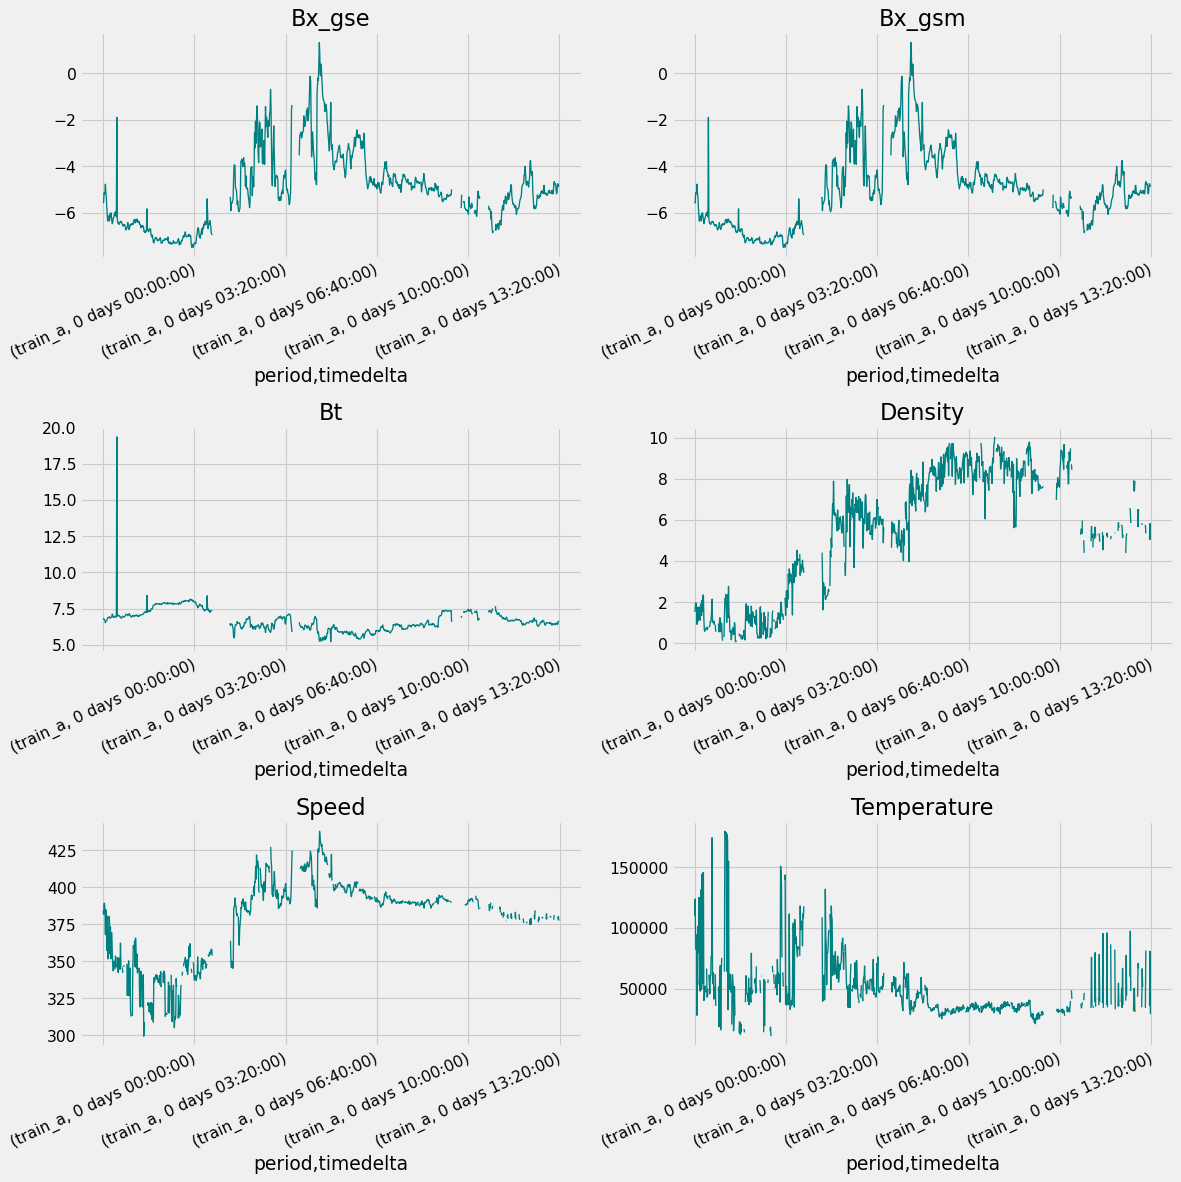

In [8]:
plt.style.use('fivethirtyeight')
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,color='teal', lw=1.2
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [9]:
solar_wind.isnull().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

<Figure size 1440x1080 with 0 Axes>

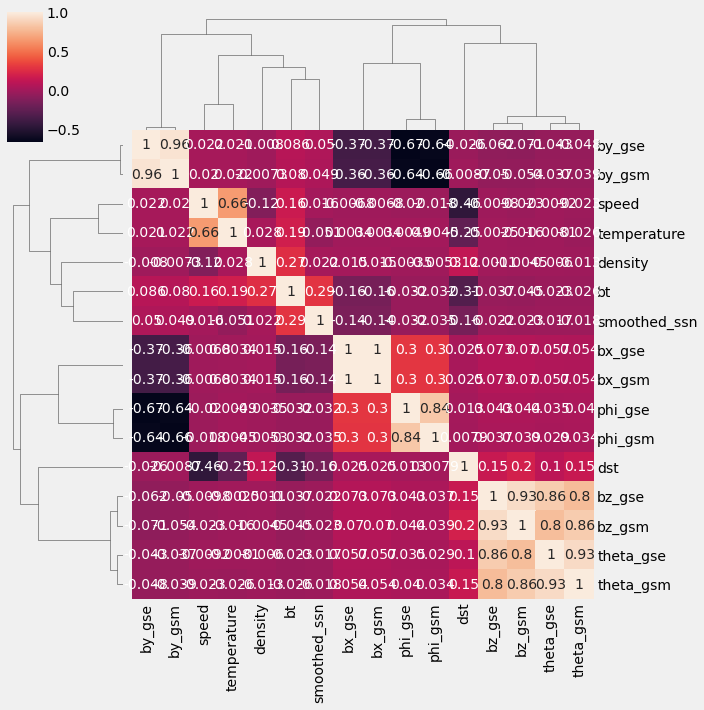

In [10]:
joined = solar_wind.join(sunspots).join(dst).fillna(method="ffill")

plt.figure(figsize=(20, 15))
sns.clustermap(joined.corr(), annot=True)

In [11]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

In [12]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [13]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [14]:
assert (features.isna().sum() == 0).all()

In [15]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [16]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

# Train a LSTM model with keras

## Create the model

In [119]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = data.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

In [120]:
import tensorflow as tf
from keras import preprocessing

data_config = {"timesteps": 12, "batch_size": 500}

def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 245
Number of val batches: 18


In [121]:
print(val_ds)

<ConcatenateDataset shapes: ((None, None, 15), (None, 2)), types: (tf.float64, tf.float64)>


In [122]:
# Printing the final loss and accuracy once the training is complete        
def print_training_info(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    print('Model loss {0:g}; Val loss {1:g}'.format(loss[-1], val_loss[-1]))

In [168]:
def generate_model(batch_input_shape, output_dim, n_layer, n_hidden,
                   optimizer_meth, act_fcn, act_fcn_output, model_config, learning_rate, reg):
    model = Sequential()
    """
    input_dim:           the size of input vector
    output_dim:          the size of output vector
    n_layer:             number of hidden layers in the network
    n_hidden:            a list of number of hidden units in each hidden layer. 
                         for example, for n_hidden=3, this can be [200, 100, 45]
    optimizer_meth:      the optimization method used for training
    act_fcn              the type of activation function in the hidden layers
    act_fcn_output       the type of activation function in the output layer
    learning_rate        Learning rate used in the training phase
    reg                  L2 regularization coefficient
    """
    
    model.add(LSTM(n_hidden[0],activation='relu', 
                   batch_input_shape=batch_input_shape,
                   stateful=model_config["stateful"],
                   dropout=model_config["dropout"],
                   return_sequences=True))
    
    model.add(LSTM(n_hidden[1],activation=act_fcn))
    
    for i in range (2, n_layer):
        model.add(Dense(n_hidden[i], activation=act_fcn,
                        kernel_regularizer=tf.keras.regularizers.l2(l=reg)))
        #model.add(BatchNormalization())

        
    model.add(Dense(output_dim, activation=act_fcn_output, 
                    kernel_regularizer=tf.keras.regularizers.l2(l=reg)))
    #model.add(BatchNormalization())
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(), 
                  optimizer=optimizer_meth)
    
    #loss=tf.keras.losses.BinaryCrossentropy()
    
    model.optimizer.learning_rate.assign(learning_rate)
    
    return model

In [169]:
def train(model, train_ds, val_ds, batch_size, epochs, verbose=1):
    """
    model:       the DNN model (the output of generate_model)
    x_train:     input of the network
    y_train:     output of the network
    batch_size:  batch size parameter
    epochs:      number of epochs used to train the network
    validation_split:  validation/train split ration (this number is the fraction of data used as validation set)
    """
    
    #### ToDo:  use the training data and train your model. 
    
    history_model = model.fit(train_ds,
                              batch_size=batch_size,
                              epochs=epochs, 
                              verbose=1, 
                              shuffle=False,
                              validation_data=val_ds)
    

    #### hint: Plot the loss function for the training and validation set to observe your network performance.
    
    plt.plot(history_model.history['loss'], label='training')
    plt.plot(history_model.history['val_loss'], label='validation')
    plt.title('Training and Validation losses')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('No. epoch')
    plt.legend()
    plt.show()
    
    print(print_training_info(history_model))
    return history_model


In [171]:
model_config = {"n_epochs": 50, "dropout": 0.4, "stateful": False}


# usually set to (`batch_size`, `sequence_length`, `n_features`)
# setting the batch size to None allows for variable length batches
batch_input_shape = (None, data_config["timesteps"], len(XCOLS))
output_dim = len(YCOLS)
n_layer = 10
n_hidden = [30, 20, 20, 20, 20, 20, 20, 20, 20, 40]
optimizer_meth = Adam()
act_fcn = 'relu'
act_fcn_output = 'linear'
learning_rate = 0.0005
reg=0.005


model = generate_model(batch_input_shape, output_dim, n_layer, n_hidden, 
                       optimizer_meth, act_fcn, act_fcn_output, model_config, learning_rate, reg)
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 12, 30)            5520      
_________________________________________________________________
lstm_83 (LSTM)               (None, 20)                4080      
_________________________________________________________________
dense_537 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_538 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_539 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_540 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_541 (Dense)            (None, 20)              

Epoch 1/50
245/245 [==============================] - 17s 62ms/step - loss: 547.1376 - val_loss: 380.5023
Epoch 2/50
245/245 [==============================] - 16s 64ms/step - loss: 306.7479 - val_loss: 330.8152
Epoch 3/50
245/245 [==============================] - 16s 64ms/step - loss: 281.5048 - val_loss: 325.9055
Epoch 4/50
245/245 [==============================] - 16s 64ms/step - loss: 271.6806 - val_loss: 306.3110
Epoch 5/50
245/245 [==============================] - 16s 64ms/step - loss: 266.6249 - val_loss: 293.9532
Epoch 6/50
245/245 [==============================] - 17s 69ms/step - loss: 259.7382 - val_loss: 284.3375
Epoch 7/50
245/245 [==============================] - 16s 64ms/step - loss: 255.4390 - val_loss: 281.4118
Epoch 8/50
245/245 [==============================] - 16s 65ms/step - loss: 250.5247 - val_loss: 289.4548
Epoch 9/50
245/245 [==============================] - 16s 64ms/step - loss: 249.8145 - val_loss: 278.6292
Epoch 10/50
245/245 [=========================

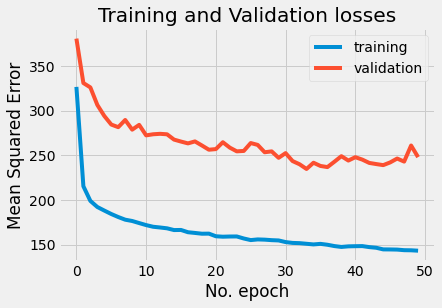

Model loss 143.168; Val loss 247.881
None


In [172]:
batch_size=data_config["batch_size"]
epochs = model_config["n_epochs"]

history = train(model, train_ds, val_ds, batch_size, epochs, verbose=1)

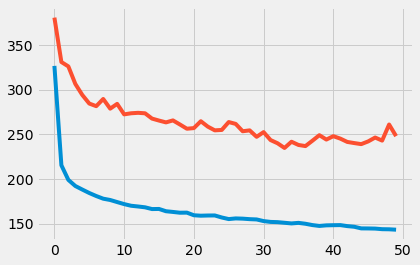

In [173]:
for name, values in history.history.items():
    plt.plot(values)

In [174]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.2f}")

36/36 [==============================] - 2s 43ms/step - loss: 226.2922
Test RMSE: 15.04


## Hyper-parameter selection

In [135]:
# hyper-parameter selection function:

def hyp_tuning(model_config, data_config, output_dim, train_ds, val_ds, batch_size, epochs, 
               learning_rate, regularization):
    """
    ToDo: find the optimal combination of learning rate and regularization coefficient.
    add more inputs to the function if necessary
    
    x_train:     input of the network
    y_train:     output of the network
    learning_rate: different values of learning rate used as hyper-parameter
    regularization: different values of regularization coefficient used as hyper-parameter
    
    opt_lr:  the optimal learning rate
    opt_reg: the optimal regularization coefficient
    """


    # usually set to (`batch_size`, `sequence_length`, `n_features`)
    # setting the batch size to None allows for variable length batches
    batch_input_shape = (None, data_config["timesteps"], len(XCOLS))
    n_layer = 10
    n_hidden = [30, 20, 20, 20, 20, 20, 20, 20, 20, 40]
    optimizer_meth = Adam()
    act_fcn = 'relu'
    act_fcn_output = 'linear'
    loss_min = 10000

    #### hint: You may need to call generate_model() and train() functions here
    for lr in learning_rate:
        for reg in regularization:
            model = generate_model(batch_input_shape, output_dim, n_layer, n_hidden, 
                       optimizer_meth, act_fcn, act_fcn_output, model_config, lr, reg)
            history_model = train(model, train_ds, val_ds, batch_size, epochs, verbose=1)
            
            val_loss = history_model.history['val_loss'][-1]
            if val_loss < loss_min:
                loss_min = val_loss
                opt_lr = lr
                opt_reg = reg
    
    return opt_lr, opt_reg

Epoch 1/5
245/245 [==============================] - 17s 62ms/step - loss: 635.3715 - val_loss: 611.1115
Epoch 2/5
245/245 [==============================] - 16s 65ms/step - loss: 494.6411 - val_loss: 406.0845
Epoch 3/5
245/245 [==============================] - 15s 61ms/step - loss: 354.9333 - val_loss: 368.3121
Epoch 4/5
245/245 [==============================] - 13s 55ms/step - loss: 317.4025 - val_loss: 333.6145
Epoch 5/5
245/245 [==============================] - 13s 52ms/step - loss: 292.3085 - val_loss: 314.8862


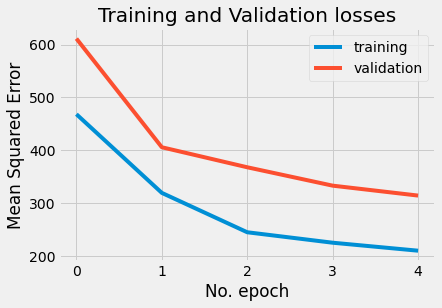

Model loss 210.863; Val loss 314.886
None
Epoch 1/5
245/245 [==============================] - 15s 54ms/step - loss: 576.4398 - val_loss: 317.7734
Epoch 2/5
245/245 [==============================] - 13s 51ms/step - loss: 317.4310 - val_loss: 301.2033
Epoch 3/5
245/245 [==============================] - 12s 49ms/step - loss: 288.5436 - val_loss: 294.2447
Epoch 4/5
245/245 [==============================] - 12s 49ms/step - loss: 278.9825 - val_loss: 289.4963
Epoch 5/5
245/245 [==============================] - 12s 50ms/step - loss: 271.7183 - val_loss: 280.3380


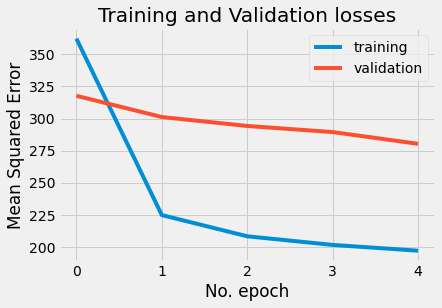

Model loss 197.053; Val loss 280.338
None
Epoch 1/5
245/245 [==============================] - 14s 50ms/step - loss: 560.5482 - val_loss: 322.5323
Epoch 2/5
245/245 [==============================] - 14s 59ms/step - loss: 316.0919 - val_loss: 300.0918
Epoch 3/5
245/245 [==============================] - 15s 61ms/step - loss: 291.3362 - val_loss: 294.2016
Epoch 4/5
245/245 [==============================] - 14s 57ms/step - loss: 284.6171 - val_loss: 289.4209
Epoch 5/5
245/245 [==============================] - 14s 59ms/step - loss: 276.9568 - val_loss: 287.3836


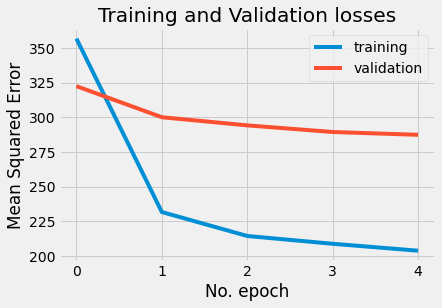

Model loss 203.711; Val loss 287.384
None
Epoch 1/5
245/245 [==============================] - 17s 61ms/step - loss: 586.8610 - val_loss: 381.7203
Epoch 2/5
245/245 [==============================] - 14s 59ms/step - loss: 321.6434 - val_loss: 335.7550
Epoch 3/5
245/245 [==============================] - 13s 52ms/step - loss: 291.4913 - val_loss: 312.7742
Epoch 4/5
245/245 [==============================] - 13s 52ms/step - loss: 279.9968 - val_loss: 299.1030
Epoch 5/5
245/245 [==============================] - 15s 60ms/step - loss: 276.9083 - val_loss: 292.0801


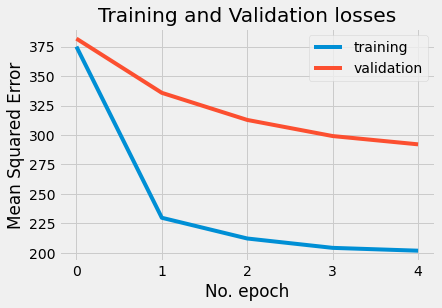

Model loss 201.897; Val loss 292.08
None
Epoch 1/5
245/245 [==============================] - 16s 59ms/step - loss: 419.7362 - val_loss: 332.7000
Epoch 2/5
245/245 [==============================] - 15s 61ms/step - loss: 265.1198 - val_loss: 321.8466
Epoch 3/5
245/245 [==============================] - 14s 56ms/step - loss: 264.2103 - val_loss: 308.9135
Epoch 4/5
245/245 [==============================] - 14s 56ms/step - loss: 257.4829 - val_loss: 285.5018
Epoch 5/5
245/245 [==============================] - 14s 56ms/step - loss: 248.3578 - val_loss: 284.1014


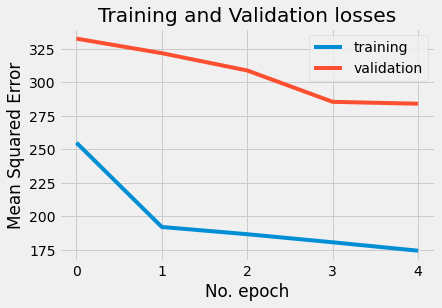

Model loss 174.356; Val loss 284.101
None
Epoch 1/5
245/245 [==============================] - 15s 52ms/step - loss: 427.3239 - val_loss: 329.7290
Epoch 2/5
245/245 [==============================] - 13s 55ms/step - loss: 279.4163 - val_loss: 310.8564
Epoch 3/5
245/245 [==============================] - 14s 55ms/step - loss: 270.4703 - val_loss: 306.3068
Epoch 4/5
245/245 [==============================] - 14s 58ms/step - loss: 265.3864 - val_loss: 303.5258
Epoch 5/5
245/245 [==============================] - 14s 56ms/step - loss: 259.4343 - val_loss: 300.8236


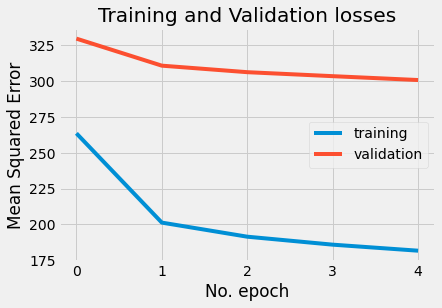

Model loss 181.704; Val loss 300.824
None
Epoch 1/5
245/245 [==============================] - 15s 55ms/step - loss: 438.7692 - val_loss: 332.8749
Epoch 2/5
245/245 [==============================] - 14s 59ms/step - loss: 295.6100 - val_loss: 335.0511
Epoch 3/5
245/245 [==============================] - 15s 59ms/step - loss: 284.9992 - val_loss: 321.2905
Epoch 4/5
245/245 [==============================] - 13s 54ms/step - loss: 271.2429 - val_loss: 316.6248
Epoch 5/5
245/245 [==============================] - 14s 58ms/step - loss: 266.6232 - val_loss: 325.2279


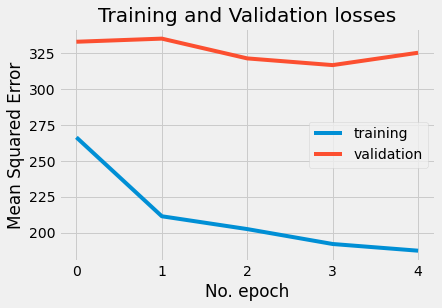

Model loss 187.505; Val loss 325.228
None
Epoch 1/5
245/245 [==============================] - 16s 56ms/step - loss: 446.3286 - val_loss: 343.6474
Epoch 2/5
245/245 [==============================] - 13s 52ms/step - loss: 300.0238 - val_loss: 332.0408
Epoch 3/5
245/245 [==============================] - 14s 56ms/step - loss: 290.6489 - val_loss: 318.0227
Epoch 4/5
245/245 [==============================] - 14s 56ms/step - loss: 280.2879 - val_loss: 316.5345
Epoch 5/5
245/245 [==============================] - 14s 57ms/step - loss: 275.5632 - val_loss: 313.2717


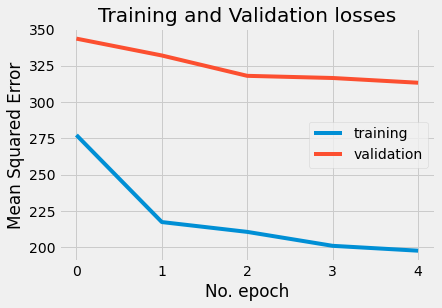

Model loss 197.618; Val loss 313.272
None
Epoch 1/5
245/245 [==============================] - 14s 53ms/step - loss: 3484.7562 - val_loss: 548.7487
Epoch 2/5
245/245 [==============================] - 15s 60ms/step - loss: 461.8153 - val_loss: 509.1978
Epoch 3/5
245/245 [==============================] - 15s 61ms/step - loss: 402.3021 - val_loss: 480.9519
Epoch 4/5
245/245 [==============================] - 15s 63ms/step - loss: 387.5467 - val_loss: 464.6415
Epoch 5/5
245/245 [==============================] - 16s 65ms/step - loss: 345.7757 - val_loss: 440.1951


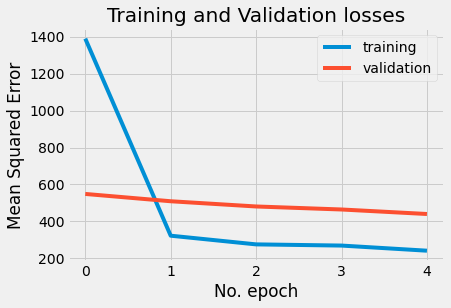

Model loss 241.707; Val loss 440.195
None
Epoch 1/5
245/245 [==============================] - 17s 64ms/step - loss: 491.2477 - val_loss: 446.7158
Epoch 2/5
245/245 [==============================] - 17s 67ms/step - loss: 289.2780 - val_loss: 418.0204
Epoch 3/5
245/245 [==============================] - 15s 60ms/step - loss: 277.4696 - val_loss: 409.1693
Epoch 4/5
245/245 [==============================] - 15s 60ms/step - loss: 290.2128 - val_loss: 402.4666
Epoch 5/5
245/245 [==============================] - 15s 60ms/step - loss: 294.4879 - val_loss: 397.4848


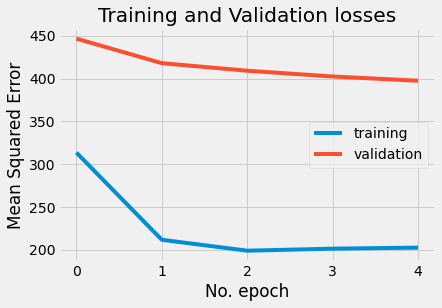

Model loss 202.412; Val loss 397.485
None
Epoch 1/5
245/245 [==============================] - 14s 51ms/step - loss: 70163.0917 - val_loss: 560.1358
Epoch 2/5
245/245 [==============================] - 14s 57ms/step - loss: 484.9282 - val_loss: 549.5854
Epoch 3/5
245/245 [==============================] - 15s 61ms/step - loss: 487.7633 - val_loss: 547.8771
Epoch 4/5
245/245 [==============================] - 16s 65ms/step - loss: 464.4877 - val_loss: 547.6589
Epoch 5/5
245/245 [==============================] - 15s 61ms/step - loss: 450.1645 - val_loss: 494.7382


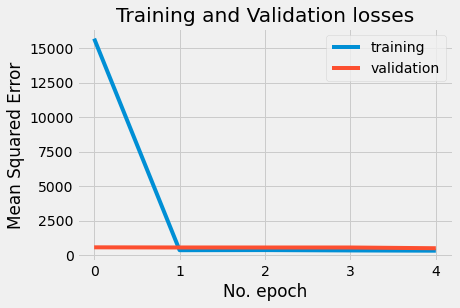

Model loss 316.31; Val loss 494.738
None
Epoch 1/5
245/245 [==============================] - 15s 55ms/step - loss: 527.2320 - val_loss: 575.6972
Epoch 2/5
245/245 [==============================] - 15s 62ms/step - loss: 497.4794 - val_loss: 559.7169
Epoch 3/5
245/245 [==============================] - 16s 63ms/step - loss: 490.8058 - val_loss: 553.6600
Epoch 4/5
245/245 [==============================] - 16s 65ms/step - loss: 488.8367 - val_loss: 548.3209
Epoch 5/5
245/245 [==============================] - 15s 61ms/step - loss: 485.8236 - val_loss: 544.5524


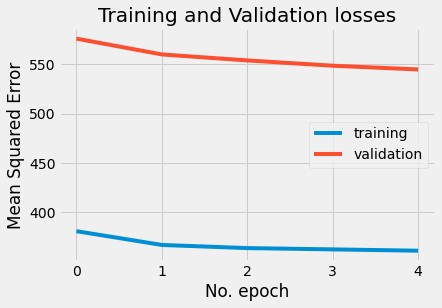

Model loss 361.375; Val loss 544.552
None
Epoch 1/5
245/245 [==============================] - 14s 52ms/step - loss: nan - val_loss: nan
Epoch 2/5
245/245 [==============================] - 12s 49ms/step - loss: nan - val_loss: nan
Epoch 3/5
245/245 [==============================] - 13s 52ms/step - loss: nan - val_loss: nan
Epoch 4/5
245/245 [==============================] - 12s 50ms/step - loss: nan - val_loss: nan
Epoch 5/5
245/245 [==============================] - 12s 49ms/step - loss: nan - val_loss: nan


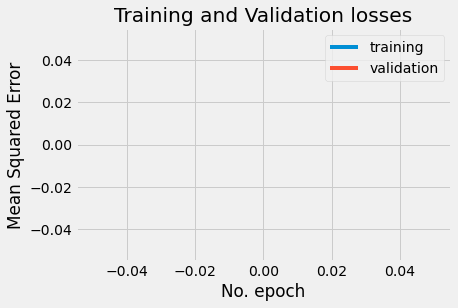

Model loss nan; Val loss nan
None
Epoch 1/5
245/245 [==============================] - 14s 53ms/step - loss: nan - val_loss: nan
Epoch 2/5
245/245 [==============================] - 14s 59ms/step - loss: nan - val_loss: nan
Epoch 3/5
245/245 [==============================] - 14s 56ms/step - loss: nan - val_loss: nan
Epoch 4/5
245/245 [==============================] - 12s 50ms/step - loss: nan - val_loss: nan
Epoch 5/5
245/245 [==============================] - 12s 50ms/step - loss: nan - val_loss: nan


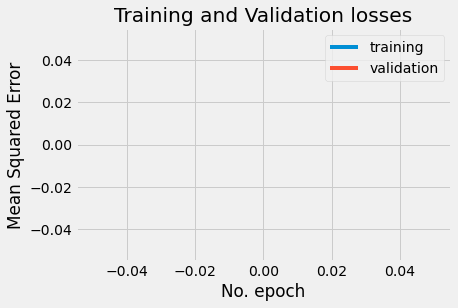

Model loss nan; Val loss nan
None
Epoch 1/5
245/245 [==============================] - 17s 66ms/step - loss: nan - val_loss: nan
Epoch 2/5
245/245 [==============================] - 18s 73ms/step - loss: nan - val_loss: nan
Epoch 3/5
245/245 [==============================] - 17s 71ms/step - loss: nan - val_loss: nan
Epoch 4/5
245/245 [==============================] - 15s 59ms/step - loss: nan - val_loss: nan
Epoch 5/5
245/245 [==============================] - 14s 57ms/step - loss: nan - val_loss: nan


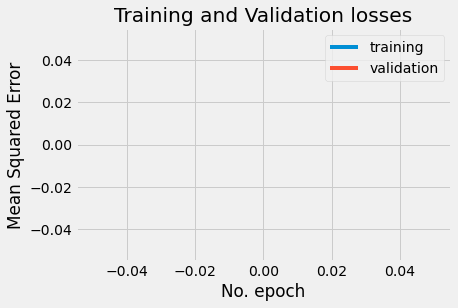

Model loss nan; Val loss nan
None
Epoch 1/5
245/245 [==============================] - 16s 60ms/step - loss: nan - val_loss: nan
Epoch 2/5
245/245 [==============================] - 14s 57ms/step - loss: nan - val_loss: nan
Epoch 3/5
245/245 [==============================] - 15s 60ms/step - loss: nan - val_loss: nan
Epoch 4/5
245/245 [==============================] - 14s 58ms/step - loss: nan - val_loss: nan
Epoch 5/5
245/245 [==============================] - 14s 56ms/step - loss: nan - val_loss: nan


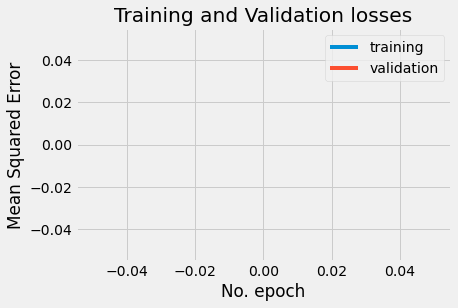

Model loss nan; Val loss nan
None


(0.0001, 0.001)

In [136]:
model_config = {"n_epochs": 5, "dropout": 0.4, "stateful": False}
output_dim = len(YCOLS)
batch_size=data_config["batch_size"]
epochs = model_config["n_epochs"]
learning_rate = [1e-4, 1e-3, 1e-2, .1]
regularization = [1e-4, 1e-3, 1e-2, .1]

        
hyp_tuning(model_config, data_config, output_dim, train_ds, val_ds, batch_size, epochs,learning_rate, regularization)

Epoch 1/5
245/245 [==============================] - 15s 55ms/step - loss: 631.8504 - val_loss: 549.6312
Epoch 2/5
245/245 [==============================] - 13s 54ms/step - loss: 466.1402 - val_loss: 402.8356
Epoch 3/5
245/245 [==============================] - 13s 54ms/step - loss: 358.2782 - val_loss: 378.0253
Epoch 4/5
245/245 [==============================] - 13s 53ms/step - loss: 323.3210 - val_loss: 349.8073
Epoch 5/5
245/245 [==============================] - 14s 55ms/step - loss: 304.3516 - val_loss: 337.5015


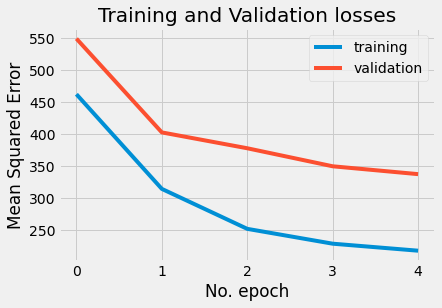

Model loss 217.674; Val loss 337.502
None
Epoch 1/5
245/245 [==============================] - 14s 52ms/step - loss: 557.9262 - val_loss: 377.7801
Epoch 2/5
245/245 [==============================] - 14s 57ms/step - loss: 319.0031 - val_loss: 321.7162
Epoch 3/5
245/245 [==============================] - 15s 62ms/step - loss: 294.9333 - val_loss: 300.8184
Epoch 4/5
245/245 [==============================] - 14s 58ms/step - loss: 284.7402 - val_loss: 293.0333
Epoch 5/5
245/245 [==============================] - 13s 53ms/step - loss: 277.7019 - val_loss: 283.4701


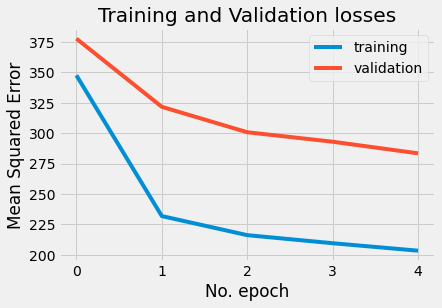

Model loss 203.451; Val loss 283.47
None
Epoch 1/5
245/245 [==============================] - 15s 53ms/step - loss: 565.9213 - val_loss: 325.4153
Epoch 2/5
245/245 [==============================] - 12s 48ms/step - loss: 339.0428 - val_loss: 304.9099
Epoch 3/5
245/245 [==============================] - 13s 53ms/step - loss: 306.3625 - val_loss: 304.4762
Epoch 4/5
245/245 [==============================] - 14s 58ms/step - loss: 295.9379 - val_loss: 297.9488
Epoch 5/5
245/245 [==============================] - 13s 53ms/step - loss: 287.3234 - val_loss: 283.5814


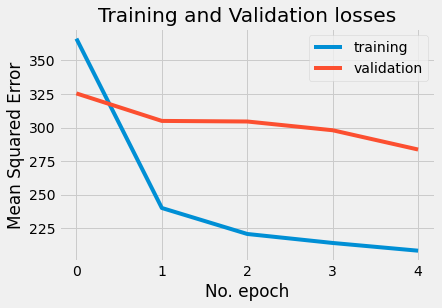

Model loss 208.139; Val loss 283.581
None
Epoch 1/5
245/245 [==============================] - 14s 52ms/step - loss: 637.1847 - val_loss: 648.1375
Epoch 2/5
245/245 [==============================] - 13s 51ms/step - loss: 635.2203 - val_loss: 645.2589
Epoch 3/5
245/245 [==============================] - 13s 51ms/step - loss: 632.6251 - val_loss: 640.3337
Epoch 4/5
245/245 [==============================] - 12s 49ms/step - loss: 628.5798 - val_loss: 632.3727
Epoch 5/5
245/245 [==============================] - 13s 51ms/step - loss: 622.2644 - val_loss: 619.9025


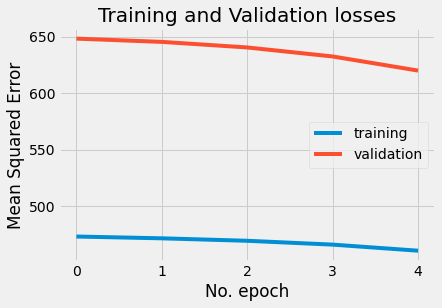

Model loss 460.791; Val loss 619.903
None
Epoch 1/5
245/245 [==============================] - 14s 52ms/step - loss: 636.7976 - val_loss: 647.5426
Epoch 2/5
245/245 [==============================] - 12s 49ms/step - loss: 632.5566 - val_loss: 642.6492
Epoch 3/5
245/245 [==============================] - 12s 49ms/step - loss: 625.2712 - val_loss: 633.4266
Epoch 4/5
245/245 [==============================] - 12s 49ms/step - loss: 611.6559 - val_loss: 610.8994
Epoch 5/5
245/245 [==============================] - 12s 49ms/step - loss: 582.2507 - val_loss: 549.6340


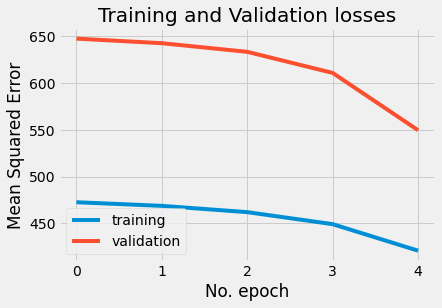

Model loss 420.873; Val loss 549.634
None
Epoch 1/5
245/245 [==============================] - 14s 50ms/step - loss: 638.4072 - val_loss: 650.4986
Epoch 2/5
245/245 [==============================] - 12s 49ms/step - loss: 637.1086 - val_loss: 649.1824
Epoch 3/5
245/245 [==============================] - 12s 47ms/step - loss: 635.4055 - val_loss: 646.8935
Epoch 4/5
245/245 [==============================] - 12s 49ms/step - loss: 632.8585 - val_loss: 643.4604
Epoch 5/5
245/245 [==============================] - 12s 49ms/step - loss: 629.1195 - val_loss: 638.1613


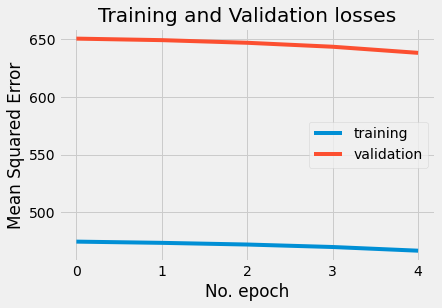

Model loss 466.699; Val loss 638.161
None
Epoch 1/5
245/245 [==============================] - 14s 53ms/step - loss: 637.8479 - val_loss: 650.6089
Epoch 2/5
245/245 [==============================] - 14s 57ms/step - loss: 637.7461 - val_loss: 650.5523
Epoch 3/5
245/245 [==============================] - 12s 49ms/step - loss: 637.6863 - val_loss: 650.5084
Epoch 4/5
245/245 [==============================] - 12s 48ms/step - loss: 637.6369 - val_loss: 650.4689
Epoch 5/5
245/245 [==============================] - 12s 48ms/step - loss: 637.5917 - val_loss: 650.4312


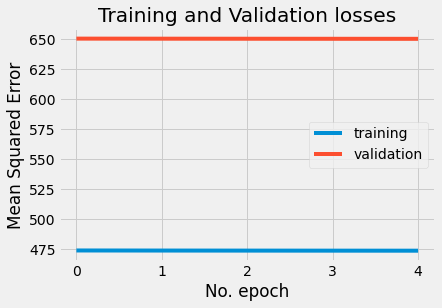

Model loss 473.965; Val loss 650.431
None
Epoch 1/5
245/245 [==============================] - 13s 49ms/step - loss: 637.9140 - val_loss: 650.6357
Epoch 2/5
245/245 [==============================] - 12s 48ms/step - loss: 637.7693 - val_loss: 650.5523
Epoch 3/5
245/245 [==============================] - 12s 48ms/step - loss: 637.6794 - val_loss: 650.4845
Epoch 4/5
245/245 [==============================] - 12s 48ms/step - loss: 637.6066 - val_loss: 650.4235
Epoch 5/5
245/245 [==============================] - 12s 48ms/step - loss: 637.5444 - val_loss: 650.3673


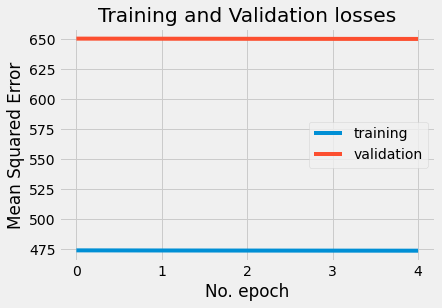

Model loss 473.983; Val loss 650.367
None
Epoch 1/5
245/245 [==============================] - 13s 49ms/step - loss: 638.8925 - val_loss: 651.6366
Epoch 2/5
245/245 [==============================] - 12s 48ms/step - loss: 638.7603 - val_loss: 651.5607
Epoch 3/5
245/245 [==============================] - 12s 49ms/step - loss: 638.6816 - val_loss: 651.4976
Epoch 4/5
245/245 [==============================] - 12s 49ms/step - loss: 638.6048 - val_loss: 651.4408
Epoch 5/5
245/245 [==============================] - 12s 47ms/step - loss: 638.5367 - val_loss: 651.3875


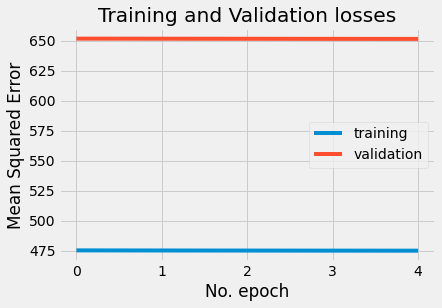

Model loss 474.898; Val loss 651.387
None
Epoch 1/5
245/245 [==============================] - 13s 49ms/step - loss: 456.1388 - val_loss: 332.6694
Epoch 2/5
245/245 [==============================] - 12s 48ms/step - loss: 285.7432 - val_loss: 322.0566
Epoch 3/5
245/245 [==============================] - 12s 48ms/step - loss: 272.1101 - val_loss: 310.1299
Epoch 4/5
245/245 [==============================] - 12s 48ms/step - loss: 262.3749 - val_loss: 300.1499
Epoch 5/5
245/245 [==============================] - 12s 48ms/step - loss: 258.3784 - val_loss: 283.1797


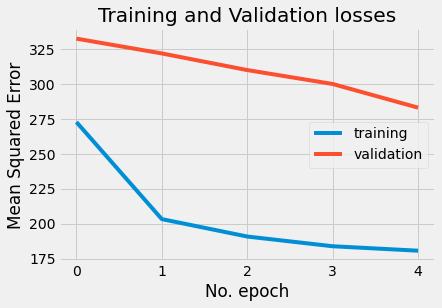

Model loss 180.638; Val loss 283.18
None
Epoch 1/5
245/245 [==============================] - 13s 49ms/step - loss: 518.9733 - val_loss: 353.2955
Epoch 2/5
245/245 [==============================] - 12s 48ms/step - loss: 304.2081 - val_loss: 345.8290
Epoch 3/5
245/245 [==============================] - 12s 47ms/step - loss: 289.9785 - val_loss: 329.2141
Epoch 4/5
245/245 [==============================] - 12s 48ms/step - loss: 276.1035 - val_loss: 310.5965
Epoch 5/5
245/245 [==============================] - 12s 48ms/step - loss: 266.7633 - val_loss: 298.0572


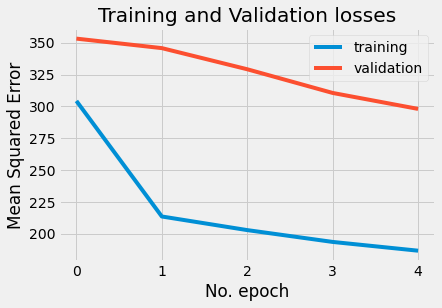

Model loss 186.608; Val loss 298.057
None
Epoch 1/5
245/245 [==============================] - 14s 51ms/step - loss: 453.0629 - val_loss: 320.2943
Epoch 2/5
245/245 [==============================] - 12s 47ms/step - loss: 282.1504 - val_loss: 319.4727
Epoch 3/5
245/245 [==============================] - 12s 48ms/step - loss: 273.9456 - val_loss: 301.1598
Epoch 4/5
245/245 [==============================] - 12s 48ms/step - loss: 263.0826 - val_loss: 287.5029
Epoch 5/5
245/245 [==============================] - 12s 50ms/step - loss: 254.5883 - val_loss: 268.1151


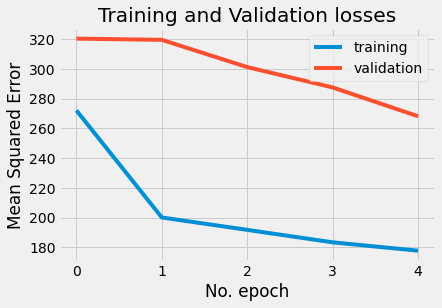

Model loss 177.8; Val loss 268.115
None


(0.0005, 0.005)

In [137]:
model_config = {"n_epochs": 5, "dropout": 0.4, "stateful": False}
output_dim = len(YCOLS)
batch_size=data_config["batch_size"]
epochs = model_config["n_epochs"]
learning_rate = [1e-4, 1e-5, 1e-6, 5*1e-4]
regularization = [1e-4, 1e-3, 5*1e-3]

        
hyp_tuning(model_config, data_config, output_dim, train_ds, val_ds, batch_size, epochs,learning_rate, regularization)

In [ ]:
# results = (0.0005, 0.005)